# Embedding

In [56]:
import matplotlib.pyplot as plt

In [25]:
import torch
import torch.nn as nn

## O que é (What is it?)

In [75]:
text_0 = '[cls] Luiz é legal [sep]'
text_1 = '[cls] Luiz é divertido [sep]'

In [76]:
tokenize_map = {
    '[pad]': 0,
    '[cls]': 1,
    'Luiz': 2,
    'divertido': 3,
    'é': 4,
    'legal': 5,
    '[sep]': 6
}

def encode(text: str, tokenize_map: dict = tokenize_map) -> list[int]:
    tokens = text.split()
    return torch.tensor([tokenize_map[token] for token in tokens])

tokens_0 = encode(text_0)
tokens_1 = encode(text_1)

In [77]:
vocab_size = len(tokenize_map)

In [78]:
print('TOKENIZANDO:\n')
print(f'TEXTO ORIGINAL: \n{text_0} \nTEXTO TOKENIZADO: \n{tokens_0}')
print(f'TEXTO ORIGINAL: \n{text_1} \nTEXTO TOKENIZADO: \n{tokens_1}')

TOKENIZANDO:

TEXTO ORIGINAL: 
[cls] Luiz é legal [sep] 
TEXTO TOKENIZADO: 
tensor([1, 2, 4, 5, 6])
TEXTO ORIGINAL: 
[cls] Luiz é divertido [sep] 
TEXTO TOKENIZADO: 
tensor([1, 2, 4, 3, 6])


## Treinando Modelo

In [94]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,  # evita IndexError: index out of range in self
            embedding_dim=2,
            padding_idx=0
        )
        self.linear = nn.Linear(2, vocab_size)


    def forward(self, x) -> torch.Tensor:
        x_emb = self.embedding(x)
        return x_emb

In [95]:
model = EmbeddingModel()

In [96]:
tokens_dummy = torch.tensor([0, 1, 2, 3, 4, 5, 6])

In [146]:
model.embedding(tokens_dummy)

tensor([[ 0.0000,  0.0000],
        [ 1.9642,  0.6969],
        [-1.4962, -0.3976],
        [-0.8052, -0.0132],
        [ 1.6599, -1.0623],
        [-0.7984,  1.2164],
        [ 0.5494, -0.2385]], grad_fn=<EmbeddingBackward0>)

In [97]:
emb_dummy = model(tokens_dummy)

Essa é a nossa visualização da incorporação dos tokens:

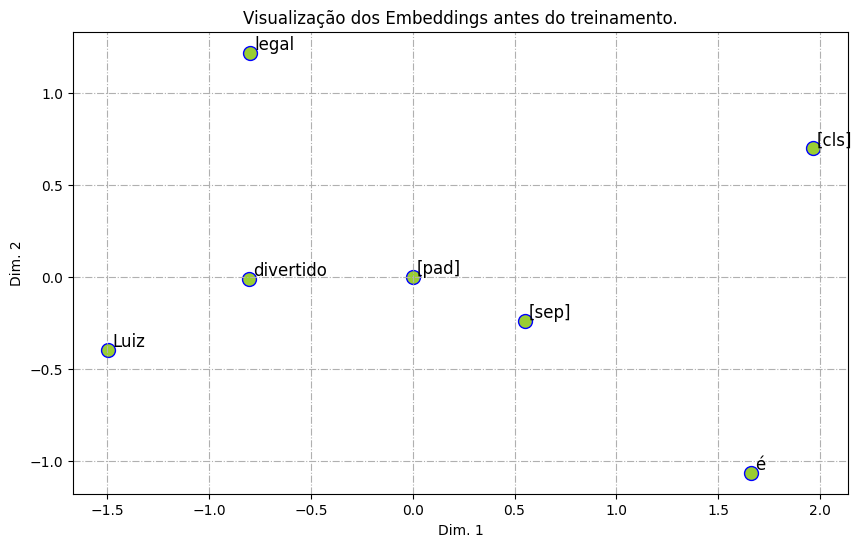

In [112]:
labels = list(tokenize_map.keys())

fig, ax = plt.subplots(figsize=(10, 6))
for i, (x, y) in enumerate(emb_dummy):
    ax.scatter(x.item(), y.item(), color='#9ACD32', edgecolors='b', s=100)
    ax.text(x.item() + 0.02, y.item() + 0.02, labels[i], fontsize=12)


ax.set_title('Visualização dos Embeddings antes do treinamento.')
ax.set_xlabel('Dim. 1')
ax.set_ylabel('Dim. 2')
plt.grid(True, linestyle='-.')

plt.show()

# Dataset

In [115]:
from torch.utils.data import DataLoader, Dataset

In [117]:
data = [text_0, text_1]

In [173]:
class EmbDataset(Dataset):
    def __init__(self, data: list[str]) -> None:
        self.data = data
        self.prepare_data = self._prepare_data()

    def __getitem__(self, id_i):
        item = self.prepare_data[id_i]
        return torch.tensor(item[0]), torch.tensor(item[1])
        

    def __len__(self):
        return len(self.prepare_data)

    def _prepare_data(self):
        data_tokens = [encode(text) for text in self.data]
        self.prepare_data = [pair for tensor in data_tokens for pair in self.__extract_pairs(tensor)] 
        return self.prepare_data
        
        
    def __extract_pairs(self, tensor):
        return [[tensor[i].item(), tensor[i+1].item()] for i in range(len(tensor) - 1)]

In [174]:
train_dataset = EmbDataset(data)

In [175]:
train_dataset.prepare_data

[[1, 2], [2, 4], [4, 5], [5, 6], [1, 2], [2, 4], [4, 3], [3, 6]]

In [177]:
X, y = train_dataset[0]

In [178]:
model.embedding(X)

tensor([1.9642, 0.6969], grad_fn=<EmbeddingBackward0>)

In [179]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=4)

In [182]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,  # evita IndexError: index out of range in self
            embedding_dim=2,
            padding_idx=0
        )
        self.linear = nn.Linear(2, vocab_size)


    def forward(self, x) -> torch.Tensor:
        x_emb = self.embedding(x)
        x_out = self.linear(x_emb)
        return x_out

In [183]:
model = EmbeddingModel()

In [188]:
y_hat = model(X)

In [189]:
y

tensor([5, 2, 2, 3])

In [196]:
EPOCHS = 500
LR = 0.05

In [197]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [198]:
criterion(y_hat, y)

tensor(0.1719, grad_fn=<NllLossBackward0>)

In [199]:
for epoch in range(EPOCHS):
    for X, y in train_loader:
        model.train()
        optimizer.zero_grad(set_to_none=True)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'epoch: {epoch} | loss: {loss.item()}')

epoch: 0 | loss: 0.34657883644104004
epoch: 10 | loss: 0.1705336719751358
epoch: 20 | loss: 0.0
epoch: 30 | loss: 0.0
epoch: 40 | loss: 0.0
epoch: 50 | loss: 0.0
epoch: 60 | loss: 0.17404374480247498
epoch: 70 | loss: 0.17742881178855896
epoch: 80 | loss: 0.1767226755619049
epoch: 90 | loss: 0.17741428315639496
epoch: 100 | loss: 0.1756402999162674
epoch: 110 | loss: 0.346585214138031
epoch: 120 | loss: 0.1759909689426422
epoch: 130 | loss: 0.17466525733470917
epoch: 140 | loss: 0.1745143085718155
epoch: 150 | loss: 0.0
epoch: 160 | loss: 0.17418278753757477
epoch: 170 | loss: 0.17210282385349274
epoch: 180 | loss: 0.34657496213912964
epoch: 190 | loss: 0.1746034026145935
epoch: 200 | loss: 0.17603933811187744
epoch: 210 | loss: 0.34657740592956543
epoch: 220 | loss: 0.0
epoch: 230 | loss: 0.17735272645950317
epoch: 240 | loss: 0.1720440685749054
epoch: 250 | loss: 0.0
epoch: 260 | loss: 0.3465805649757385
epoch: 270 | loss: 0.34657391905784607
epoch: 280 | loss: 0.0
epoch: 290 | loss:

In [200]:
tokens_dummy = torch.tensor([0, 1, 2, 3, 4, 5, 6])

In [206]:
model.embedding(tokens_dummy)

tensor([[ 0.0000,  0.0000],
        [-7.8289, -9.2582],
        [-0.8430, -9.5394],
        [-7.2704,  0.3825],
        [ 0.0610,  0.0117],
        [-7.2818,  0.2919],
        [ 1.0832,  0.5078]], grad_fn=<EmbeddingBackward0>)

In [205]:
emb = model.embedding(tokens_dummy)

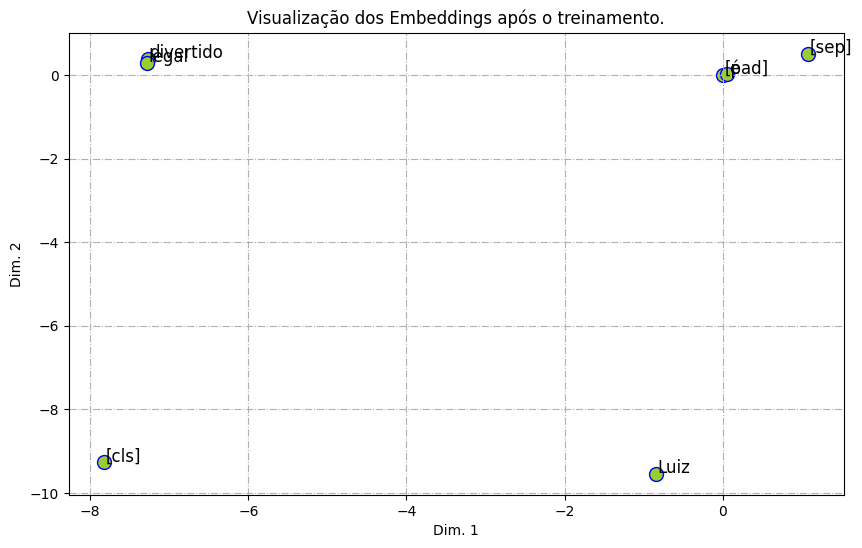

In [208]:
labels = list(tokenize_map.keys())

fig, ax = plt.subplots(figsize=(10, 6))
for i, (x, y) in enumerate(emb):
    ax.scatter(x.item(), y.item(), color='#9ACD32', edgecolors='b', s=100)
    ax.text(x.item() + 0.02, y.item() + 0.02, labels[i], fontsize=12)


ax.set_title('Visualização dos Embeddings após o treinamento.')
ax.set_xlabel('Dim. 1')
ax.set_ylabel('Dim. 2')
plt.grid(True, linestyle='-.')

plt.show()